## Обработка данных о пассажирах «Титаника»

Из [Википедии](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D1%83%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%C2%AB%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA%D0%B0%C2%BB):

Крушение парохода «Титаник» — морская катастрофа, произошедшая в ночь с 14 на 15 апреля 1912 года в северной части Атлантического океана, более чем в 600 км к юго-востоку от канадского острова Ньюфаундленд. Трагедия случилась под конец пятого дня следования «Титаника» по трансатлантическому маршруту Саутгемптон — Нью-Йорк. В 23:40 14 апреля во время первого рейса самый большой на тот момент океанский лайнер с 2208 людьми на борту по касательной столкнулся с айсбергом и получил серьёзные повреждения обшивки корпуса. Спустя 2 часа 40 минут — в 2:20 15 апреля — он полностью ушёл под воду. Катастрофа унесла жизни, по разным данным, от 1495 до 1635 человек.

На сайте kaggle можно найти csv-файлы с информацией о пассажирах «Титаника». Насколько эта информация является достоверной для нас несущественно. Обработка этой информации является хорошей иллюстрацией возможностей научных библиотек языка Python. Кроме анализа имеющихся данных будут получены предсказания, полученные с помощью применения
двух методов машинного обучения.

Приведённый ниже программный код основан на [следующей работе](https://github.com/sumitmukhija/Titanic/blob/master/Tip%20of%20the%20Iceberg.ipynb), в которой проведён подробный анализ данных о пассажирах «Титаника».

Начинаем с подключения библиотек. Разных библиотек, среди которых и `sklearn`:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import warnings
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

Выполняем «тонкую настройку» параметров визуализации библиотеки Seaborn:

In [2]:
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)
custom_colors = ["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

Убираем замечания (warninigs), которые являются следствием неравномерного обновления кода различных библиотек:

In [3]:
warnings.filterwarnings('ignore')

Загружаем данные о пассажирах Титаника из csv-файла:

In [4]:
td = pd.read_csv('titanic.csv')
td

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 1. Начальное исследование данных

Каждый ряд данных соответствует одному человеку на борту «Титаника» и содержит следующую информацию о нём:

- PassengerId — индентификатор пассажира;
- Survived    — выжил ли пассажир после катастрофы;
- Pclass      — класс пассажира (1-й, 2-й или 3-й);
- Name        — имя пассажира, включающее его титул;
- Sex         — пол пассажира;
- Age         — возраст пассажира;
- SibSp       — число братьев, сестер или супругов на борту у пассажира;
- Parch       — количество родителей или детей на борту у пассажира;
- Ticket      — билет пассажира;
- Fare        — стоимость билета пассажира;
- Cabin       — каюта пассажира;
- Embarked    — порт посадки пассажира на борт: Саутгемптон (Southampton), Шербург (Cherbourg) или Куинстаун (Queenstown).

Метод `info` показывает, что в таблице 5 колонок с целыми числами (`int64`), 5 колонок типа `object` (строки) и две
колонки с действительными числами (`float64`). Мы также видим, что не все колонки содержат 1309 значений, — есть пропущенные (неизвестные) величины.

In [5]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### 2. Пропущенные (отсутствующие) значения

Простой линейный график (line plot) показывает количество отсутствующих величин в следующих колонках: 
- Age 
- Cabin
- Embarked
- Fare
- Survived

**77.5%** строк не содержат значений в колонке `Cabin`, поэтому следует исключить её из дальнейшего рассмотрения.

В колонке `Embarked` всего 2 отсутствующих величины, что составляет всего **0.15%**. В этом случае целесообразно заменить их наиболее часто встречающимся значением данной колонки (mode). Колонка `Fare` с рассматриваемой точки зрения подобна `Embarked`.

В колонке `Age` пропущенных значенией достаточно много (около **20%**). Мы попытаемся угадать пропущенные значения возраста, распределяя пассажиров по категориям в соответствии с их титулом и определяя медианный возраст каждой из категорий.

Отсутствующие значения в колонке `Survived` будут найдены с помощью применения методов машинного обучения.

Text(0.5, 1.0, 'Количество отсутствующих величин')

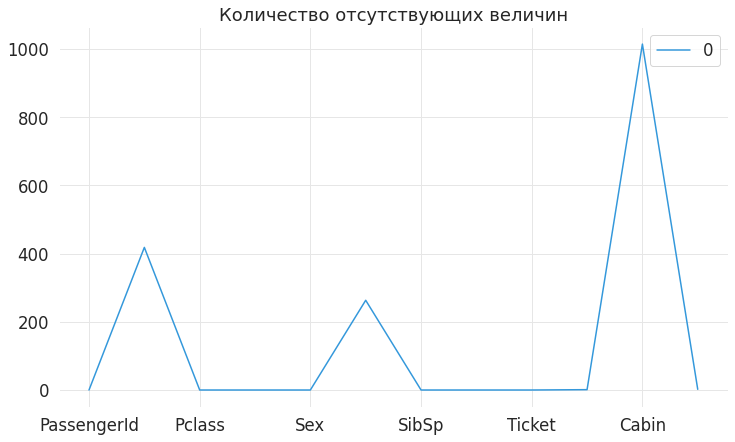

In [6]:
pd.DataFrame(td.isnull().sum()).plot.line().set_title("Количество отсутствующих величин")


### 3. Количество уникальных значений

С помощью метода `nunique` определим количество уникальных значений в колонках таблицы:

In [7]:
td.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Четыре колонки (Survived, Sex, Embarked and PClass) содержат только два или три различных значения. Можно считать, что эти значения разбивают множество всех пассажиров на **категории**. 

# Признаки (features)

**Далее мы будем рассматривать только тех пассажиров, для которых известно значение в колонке `Survived`.** Эти
данные будут называться **тренировочными**. Именно они будут использоваться в качестве обучающих данных для нахождения прогноза выживаемости пассажиров, судьба которых не известна.

### 4. Survived ###

Приведённая ниже диаграмма (horizontal bar plot) показывает процент пассажиров, которые выжили после катастрофы и процент пассажиров, которым спастись не удалось. **Более 60% пассажиров «Титаника» погибли.**

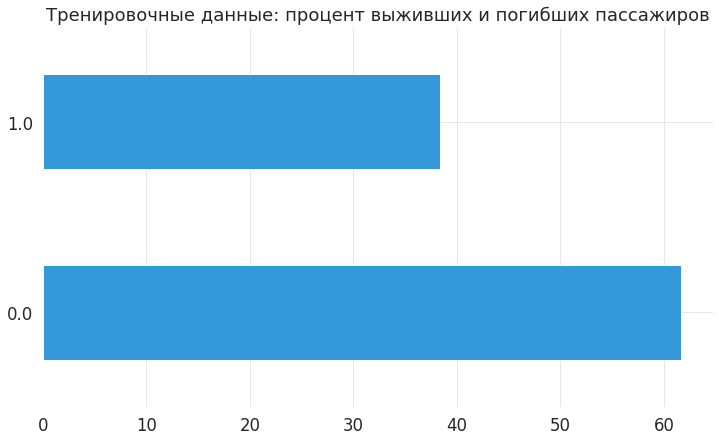

In [8]:
trd = pd.read_csv('train.csv')
(trd.Survived.value_counts(normalize=True) * 100).plot.barh().set_title("Тренировочные данные: процент выживших и погибших пассажиров")
pass

### 5. Pclass ###

Большая часть пассажиров путешествовала третьим классом **(709)**, намного меньше вторым **(277)** и чуть более этого первым **(323)**. 

**Количество пассажиров третьего первого класса было больше, чем суммарное количество пассажиров первого и второго классов.**

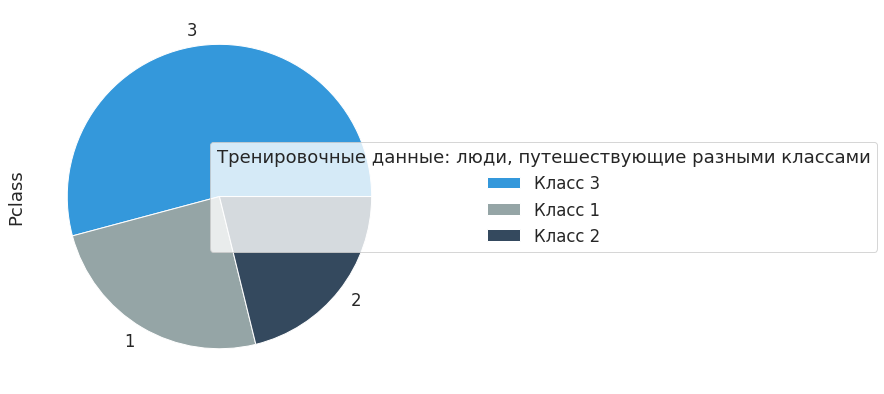

In [9]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Класс 3","Класс 1","Класс 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Тренировочные данные: люди, путешествующие разными классами")


Вот так можно подсчитать и визулизировать процент выживших пассажиров в зависимости от их класса:

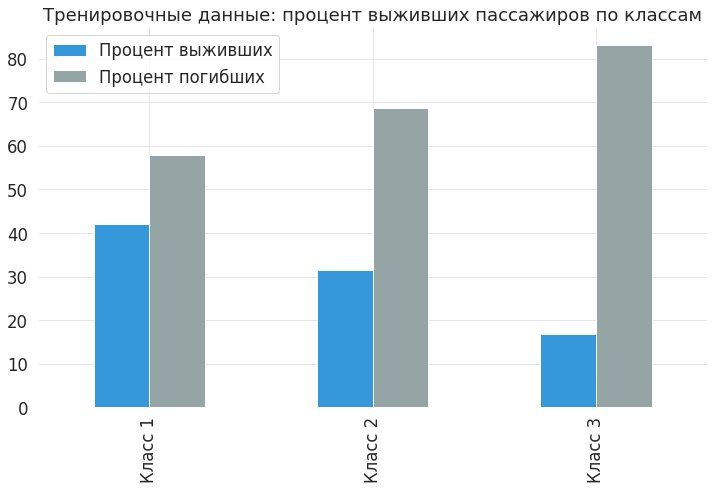

In [10]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Процент выживших":{"Класс 1": pclass_1_survivor_distribution,"Класс 2": pclass_2_survivor_distribution, "Класс 3": pclass_3_survivor_distribution},  
     "Процент погибших":{"Класс 1": 100-pclass_1_survivor_distribution,"Класс 2": 100-pclass_2_survivor_distribution, "Класс 3": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Тренировочные данные: процент выживших пассажиров по классам")
pass

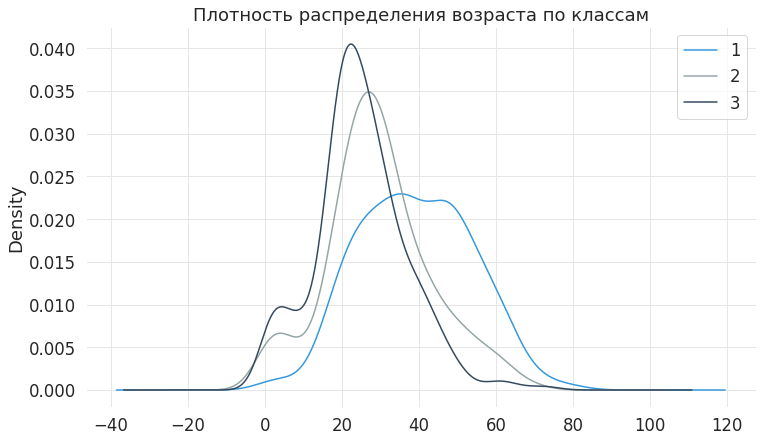

In [11]:
for x in [1,2,3]:
    trd.Age[trd.Pclass == x].plot(kind="kde")
plt.title("Плотность распределения возраста по классам")
plt.legend(("1","2","3"))
pass

In [12]:
pclass_perc_df

,Процент выживших,Процент погибших
Класс 1,42.11,57.89
Класс 2,31.41,68.59
Класс 3,16.78,83.22


### 6. Sex

Примерно **65%** пассажиров были мужчинами, однако процент выживших женщин выше: почти 80% мужчин погибли, а для женщин этот показатель составляет около 70%:

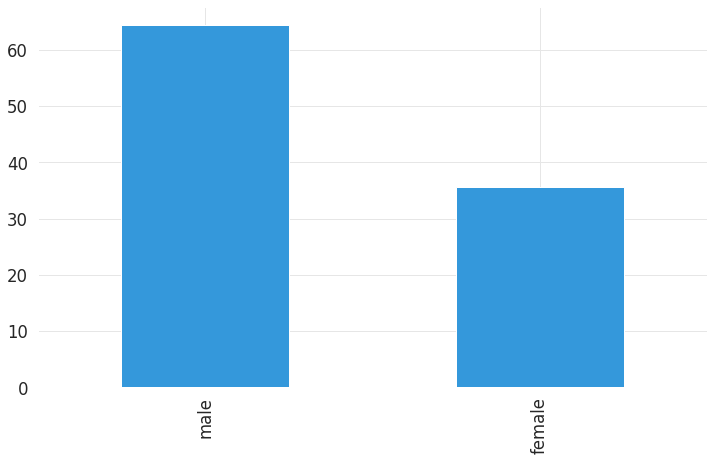

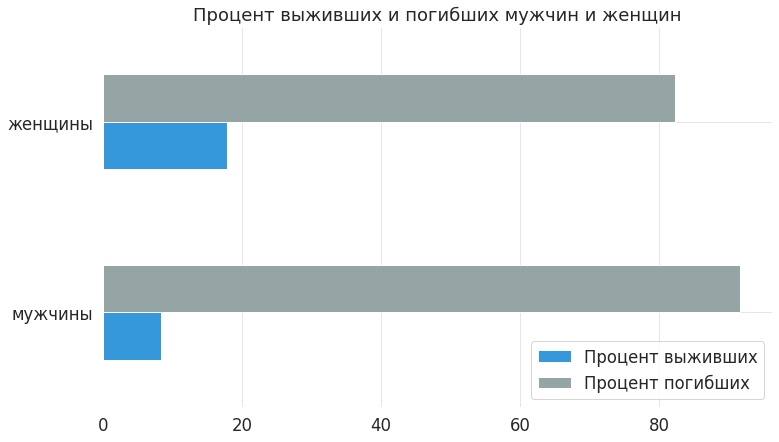

In [13]:
fig_sex = (trd.Sex.value_counts(normalize = True) * 100).plot.bar()
male_pr = round((trd[trd.Sex == 'male'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
female_pr = round((trd[trd.Sex == 'female'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
sex_perc_df = pd.DataFrame(
    { "Процент выживших":{"мужчины": male_pr,"женщины": female_pr},  "Процент погибших":{"мужчины": 100-male_pr,"женщины": 100-female_pr}})
sex_perc_df.plot.barh().set_title("Процент выживших и погибших мужчин и женщин")
fig_sex
pass

### 7. Age

Метод `describe` показывает, что самому молодому путешественнику на борту было **2 месяца**, а самому возрастному — **80 лет**. The **средний возраст был чуть менее 30 лет.**  Следует помнить, однако, что в этой колонке есть немало отсутствующих значений.

In [14]:
pd.DataFrame(td.Age.describe())

,Age
count,1046.000000
mean,29.881138
std,14.413493
min,0.170000
25%,21.000000
50%,28.000000
75%,39.000000
max,80.000000


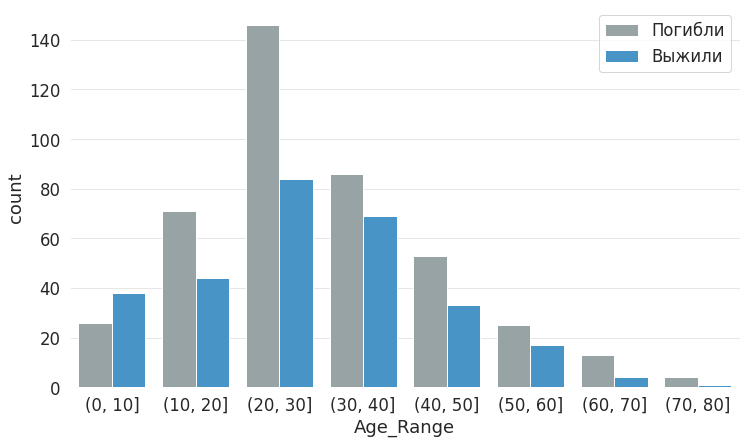

In [15]:
td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60, 70, 80])
sns.countplot(x = "Age_Range", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Погибли", "Выжили"])
pass

<AxesSubplot:xlabel='Age', ylabel='Density'>

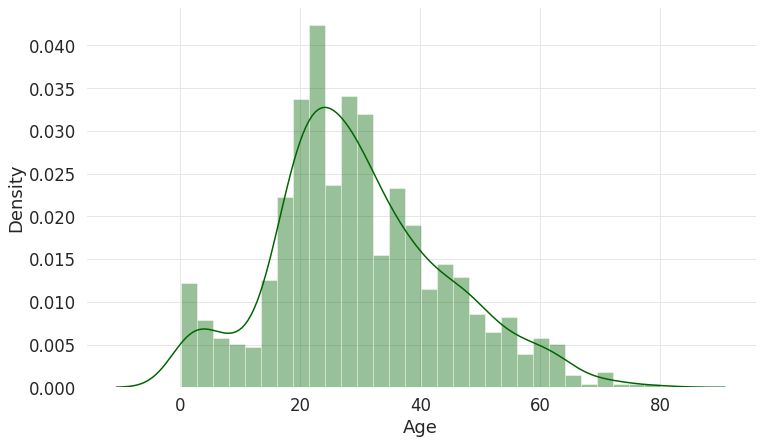

In [16]:
sns.distplot(td['Age'].dropna(),color='darkgreen',bins=30)

### 8 - 10. 

Эти колонки мы рассматривать подробно не будем. Но необходимые дейстивя для выполнения в дальнейшем задуманного сделать нужно.

In [17]:
td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

### 11. Fare

Ясно, что **чем больше пассажир заплатил, тем больше у него оказалось шансов выжить в результате аварии.**

In [18]:
td.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [19]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Низкий','Средний',
                                                                                      'Выше среднего','Высокий'])

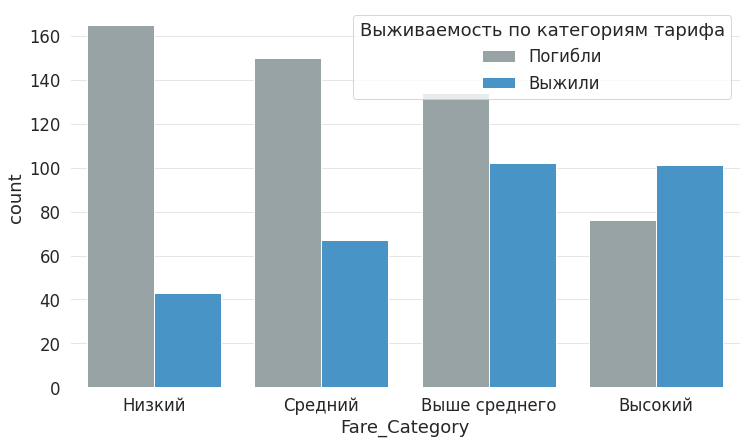

In [20]:
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Погибли", "Выжили"])
x.set_title("Выживаемость по категориям тарифа")
pass

### 12. Cabin

В этой колонке много отсутствующих значений. Мы вычислим их и затем будем использовать для предсказания выживаемости пассажиров.

### 13. Embarked

В этой колонке всего три значения, соответствующие портам посадки на «Титаник»: Southampton, Cherbourg и Queenstown.

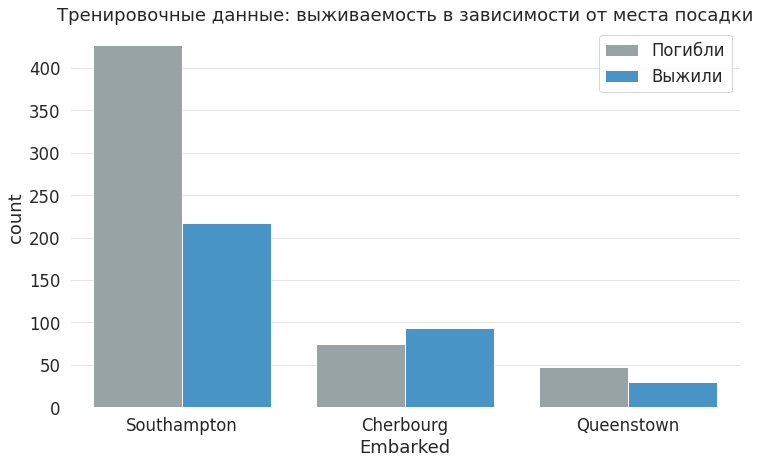

In [21]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = trd, palette=["C1", "C0"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Погибли", "Выжили"])
p.set_title("Тренировочные данные: выживаемость в зависимости от места посадки")
pass

# Замена отсутствующих значений (Data Imputation)

### Embarked

В этой колонке только два отсутствующих значения, а наибольшее число пассажиров зашло на борт в городе Southampton.
Поэтому логично заменить отсутствующие значения именно на него. Аккуратнее сделать это можно, используя функцию `mode`:

In [22]:
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

### Age

Возраст не укзан в **263** ячейках. Для адекватной замены пропущенных значений целесообразно сначала распределить всех пассажиров по категориям в соответствии с их титулом и затем заменить пропущенные величны на медианные значения соответствующих категорий. В данных встречаюется всего **17** различных титулов.

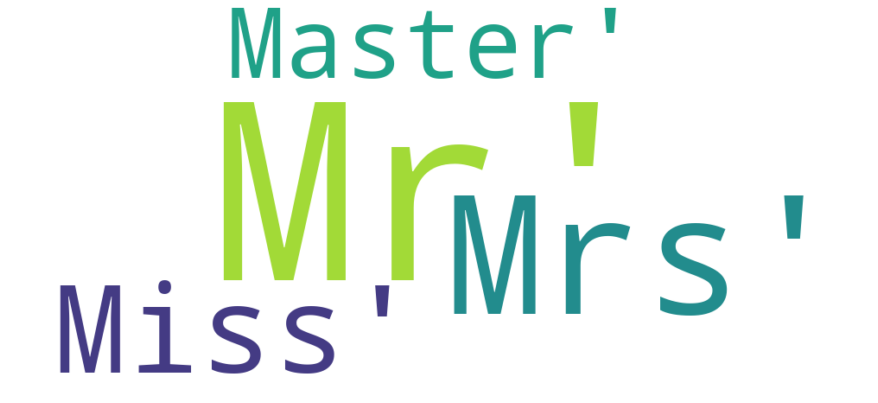

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Salutation, dtype: int64

In [23]:
td['Salutation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
td.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(td.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

td.Salutation.value_counts()

In [24]:
grp = td.groupby(['Sex', 'Pclass'])  
td.Age = grp.Age.apply(lambda x: x.fillna(x.median()))
td.Age.fillna(td.Age.median, inplace = True)

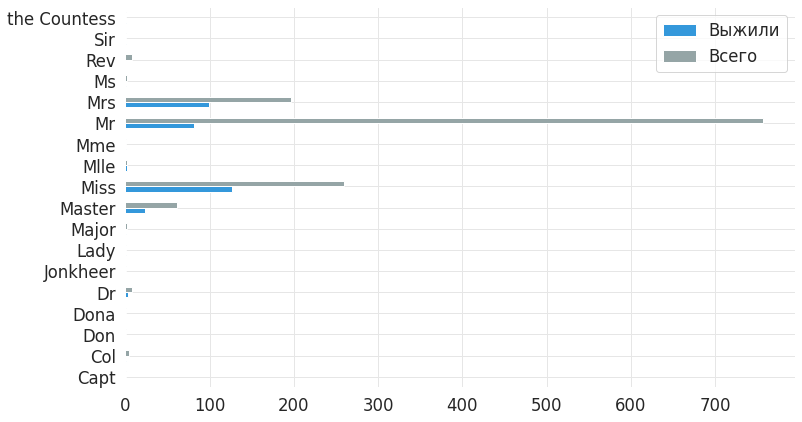

In [25]:
sal_df = pd.DataFrame({
    "Выжили":
    td[td.Survived == 1].Salutation.value_counts(),
    "Всего":
        td.Salutation.value_counts()
})
s = sal_df.plot.barh()

### Cabin

Просто запишем `NA` (Not Available) вместо пропущеннхых значений в колонке `Cabin`:

In [26]:
td.Cabin = td.Cabin.fillna('NA')

# Кодирование категориальных признаков и удаление текстовых колонок

Текстовые данные весьма непросто использовать в алгоритмах машинного обучения. Поэтому мы преобразуем их в числовые: LabelEncoder даёт возможность перекодировать строки столбца `Sex`.

Для преобразования категориальных данных стoлбcа `Cabin` используем функцию `get_dummies`, которая добавляет столбцы, соответствующие всем уникальным значениям исходного столбца.

In [27]:
td = pd.concat([td,pd.get_dummies(td.Cabin, prefix="Cabin"),pd.get_dummies(td.Age_Range, prefix="Age_Range"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Salutation, prefix="Title", drop_first = True),pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])
td

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Fare_Средний,Fare_Выше среднего,Fare_Высокий,Class_2,Class_3
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,1,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,25.0,0,0,A.5. 3236,8.0500,...,0,0,0,0,0,1,0,0,0,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,...,0,0,0,0,0,0,0,1,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,...,0,0,0,0,0,0,0,0,0,1
1307,1308,NaN,3,"Ware, Mr. Frederick",1,25.0,0,0,359309,8.0500,...,0,0,0,0,0,1,0,0,0,1


In [28]:
td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)
td

,PassengerId,Survived,Sex,Family,Is_Alone,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,...,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Fare_Средний,Fare_Выше среднего,Fare_Высокий,Class_2,Class_3
0,1,0.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,1.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,5,0.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1305,1306,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1306,1307,NaN,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1307,1308,NaN,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


# Предсказание

Будут использованы следующие алгоритмы:

1. Gaussian Naive Bayes
2. Random Forest

**Дальнейший код приводится без подробного объяснения его работы.** 

NB Accuracy: 66.48%
The cross validated score for GNB is: 65.59


Text(0.5, 1.05, 'Confusion_matrix for NB')

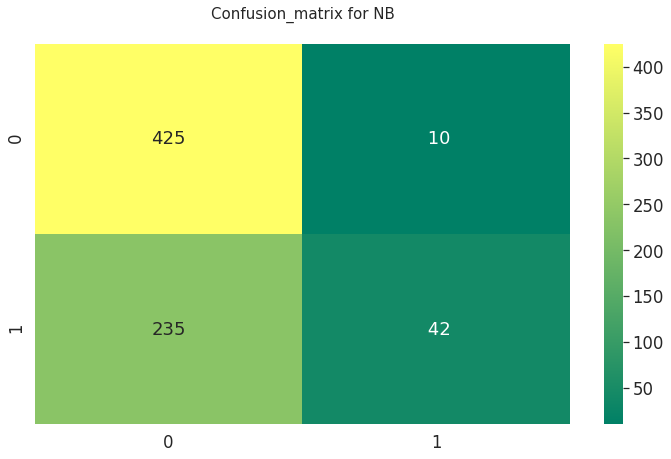

In [29]:
# Data to be predicted
X_to_be_predicted = td[td.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

# Training data
train_data = td
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape #891 x 28

# Gaussian
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("NB Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for GNB is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for NB', y=1.05, size=15)

RF Accuracy: 81.01%
The cross validated score for Random forest is: 83.72


Text(0.5, 1.05, 'Confusion_matrix for RF')

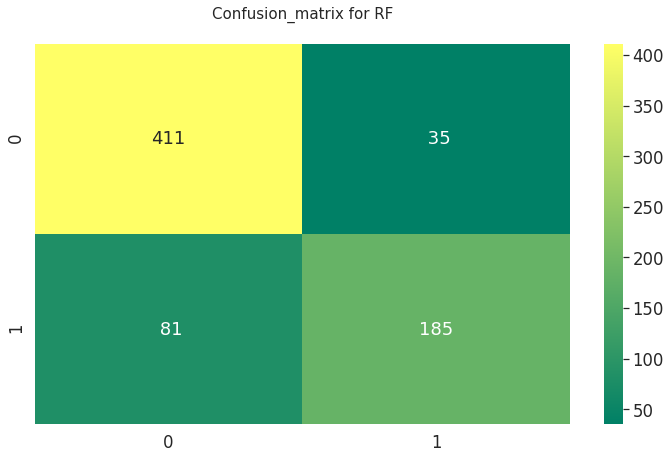

In [30]:
# Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")

result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

Результат предсказания (выжил ли пассажир с неизвестной судьбой) записывается в файл `TitanicPredictions.csv`:

In [31]:
result = clf.predict(X_to_be_predicted)
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'TitanicPredictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: TitanicPredictions.csv


In [32]:
res = pd.read_csv('TitanicPredictions.csv')
res.head(30)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
